In [4]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from pathlib import Path

# Add the correct functions path whether the notebook runs from repo root or /Q1
cwd = Path.cwd()
if (cwd / "functions").exists():
    functions_dir = cwd / "functions"
else:
    functions_dir = cwd / "Q1" / "functions"

sys.path.insert(0, str(functions_dir))

from eval_utils import evaluate_model


# Load the preprocessed datasets
train_df = pd.read_csv('train_df_processed.csv')
test_df = pd.read_csv('test_df_processed.csv')

# Remove any null values that may have been created during I/O
train_df = train_df.dropna(subset=['processed_text'])
test_df = test_df.dropna(subset=['processed_text'])

# Define target labels
y_train = train_df['sentiment_class']
y_test = test_df['sentiment_class']

## Vectorization

In [42]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(3, 5), analyzer="char_wb", min_df=2) 

X_train = vectorizer.fit_transform(train_df['processed_text'])
X_test = vectorizer.transform(test_df['processed_text'])

print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"Matrix type: {type(X_train)}")

Vocabulary size: 5000
Matrix type: <class 'scipy.sparse._csr.csr_matrix'>


## After Vectorization Cleaning

In [43]:
# Ensure that the vectorized matrix matches the dimensions of our labels
print(f"Training set shape (Samples, Features): {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape (Samples, Features): (27463, 5000)
Test set shape: (3531, 5000)


## Modeling

In [44]:
# Applying a Multinomial Naive Bayes as the classical ML baseline (q1)
model = MultinomialNB()
model.fit(X_train, y_train)

# Generate predictions for evaluation
y_pred = model.predict(X_test)

## Results

--- Results for Naive Bayes + TF-IDF ---
Accuracy: 0.6525

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.58      0.62      1001
           1       0.59      0.73      0.65      1427
           2       0.76      0.62      0.69      1103

    accuracy                           0.65      3531
   macro avg       0.67      0.64      0.65      3531
weighted avg       0.67      0.65      0.65      3531



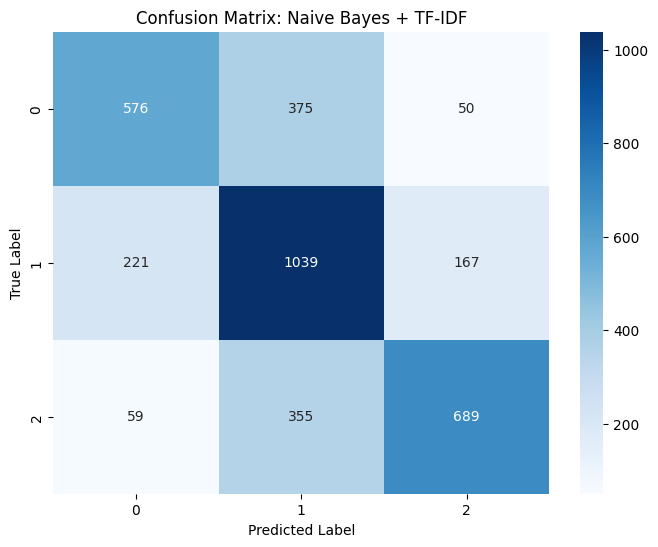

In [45]:
# Use the shared function to display performance metrics (q3 analysis)
evaluate_model(y_test, y_pred, "Naive Bayes + TF-IDF")